# QML Challenge

In this challenge, participants will develop a model to predict PM25 levels based on humidity and PM10 measurements. This challenge simulates a real-world scenario where we want to estimate fine particulate matter (PM25) using more easily measurable parameters.

In [24]:
%pip install seaborn pandas scikit-learn torch pennylane qbraid-core 

import pandas as pd
import torch
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
# read in the data set

df = pd.read_csv('./particolato.csv',index_col=0, dtype={ "sensors.humidify": "int64", "sensors.pm10":"float64", "sensors.pm25":"float64"}, parse_dates=["Time"])




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 MB 279.4 kB/s eta 0:00:00m eta 0:00:010:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 238.9 kB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 272.8 kB/s eta 0:00:001m278.2 kB/s eta 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
Note: you may need to restart the kernel to use updated packages.


In [34]:
# okay lets try doing some EDA on this 

df.dropna(inplace=True)
# Display the first few rows
print(df.head())

# Basic information about the dataset
print(df.info())

# Summary statistics
print(df.describe())

                     sensors.humidity  sensors.pm10  sensors.pm25  hour  \
Time                                                                      
2024-05-05 00:00:00              92.0           6.0           1.8     0   
2024-05-05 01:00:00              97.0           4.5           1.8     1   
2024-05-05 02:00:00              95.0           6.8           2.0     2   
2024-05-05 03:00:00              96.0           4.1           1.6     3   
2024-05-05 04:00:00              91.0           4.2           1.5     4   

                     day_of_week  
Time                              
2024-05-05 00:00:00            6  
2024-05-05 01:00:00            6  
2024-05-05 02:00:00            6  
2024-05-05 03:00:00            6  
2024-05-05 04:00:00            6  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1239 entries, 2024-05-05 00:00:00 to 2024-06-26 23:00:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -

<Figure size 1200x800 with 0 Axes>

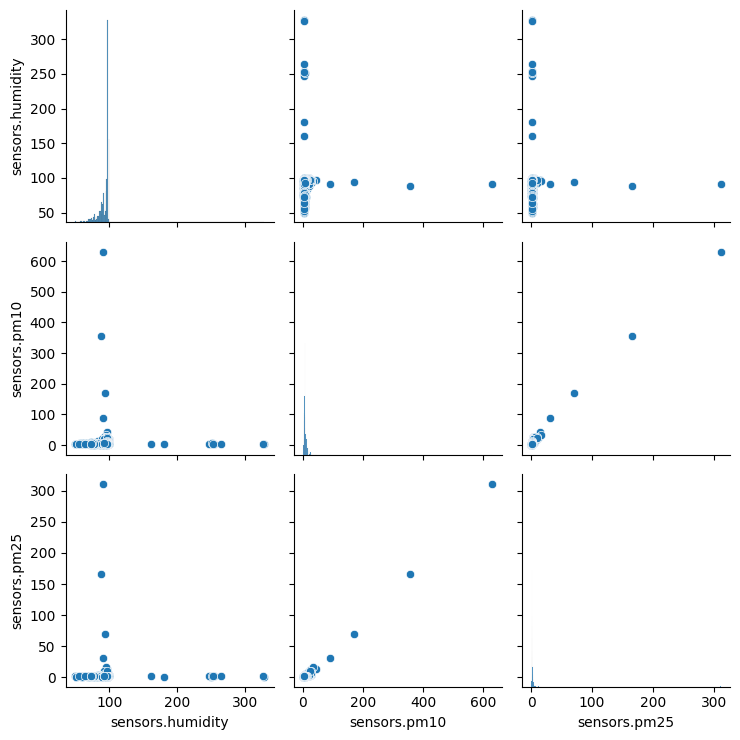

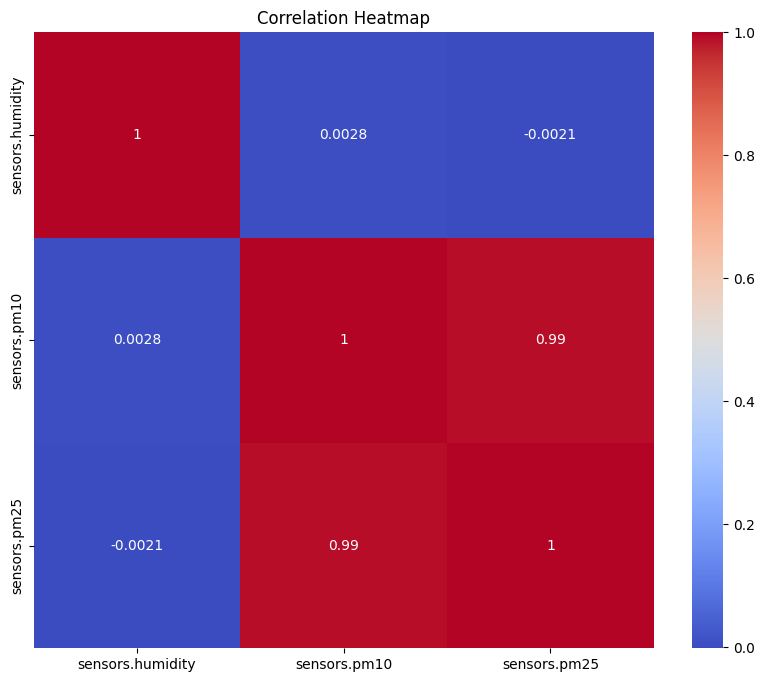

In [35]:
# EDA
plt.figure(figsize=(12, 8))
sns.pairplot(df[['sensors.humidity', 'sensors.pm10', 'sensors.pm25']])
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[['sensors.humidity', 'sensors.pm10', 'sensors.pm25']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


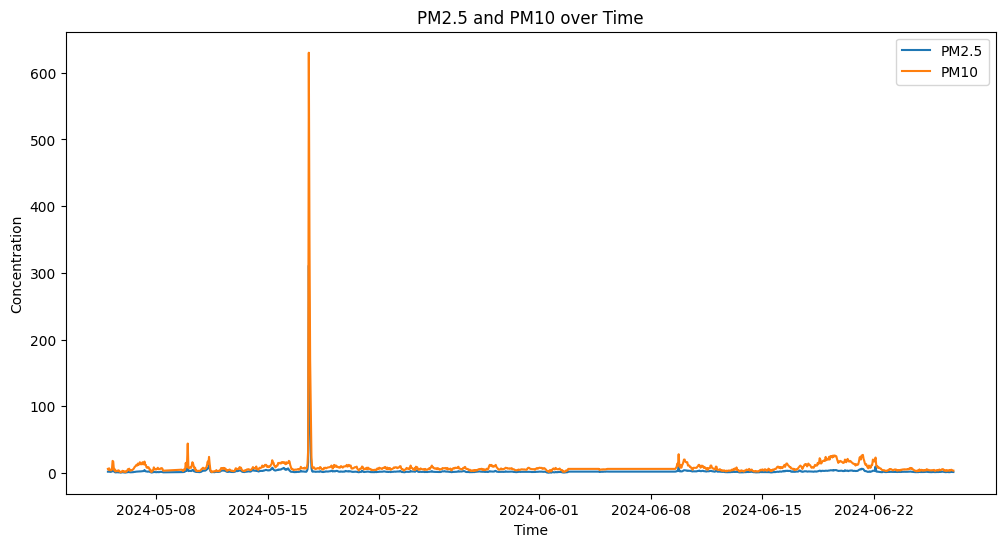

In [36]:
# Time series plot
plt.figure(figsize=(12, 6))
plt.plot( df['sensors.pm25'], label='PM2.5')
plt.plot( df['sensors.pm10'], label='PM10')
plt.title('PM2.5 and PM10 over Time')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()


In [37]:

# Feature Engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek

In [38]:
import torch
# Split the data
X = df[['sensors.humidity', 'sensors.pm10', 'hour', 'day_of_week']]
y = df['sensors.pm25']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)


In [81]:
import pennylane as qml
import torch

# Set default tensor type to float32
torch.set_default_tensor_type(torch.FloatTensor)

# Define the quantum device
n_features = X_train.shape[1]
print(f"Number of features: {n_features}")

n_qubits = min(n_features, 10)  # Limit the number of qubits to a maximum of 10

# Define the quantum circuit
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

class HybridModel(torch.nn.Module):
    def __init__(self, n_features, n_qubits):
        super().__init__()
        self.n_features = n_features
        self.n_qubits = n_qubits
        self.pre_net = torch.nn.Linear(n_features, n_qubits)
        self.q_params = torch.nn.Parameter(torch.randn(3, n_qubits))
        self.post_net = torch.nn.Linear(n_qubits, 1)

    def forward(self, x):
        x = self.pre_net(x)
        x = torch.stack([torch.tensor(quantum_circuit(x_i.unsqueeze(0) if x_i.dim() == 0 else x_i, self.q_params), dtype=torch.float32) for x_i in x])
        x = self.post_net(x)
        return x

# Initialize the model
model = HybridModel(n_features, n_qubits)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Ensure input data is float32
X_train_tensor = X_train_tensor.float()
y_train_tensor = y_train_tensor.float()
X_test_tensor = X_test_tensor.float()
y_test_tensor = y_test_tensor.float()

# Training loop
epochs = 10
batch_size = 32

for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)

mae = mean_absolute_error(y_test, y_pred.numpy())
print(f"Mean Absolute Error: {mae:.4f}")

Number of features: 4
Epoch [10/10], Train Loss: 0.8374, Val Loss: 1.1805
Mean Absolute Error: 0.7618


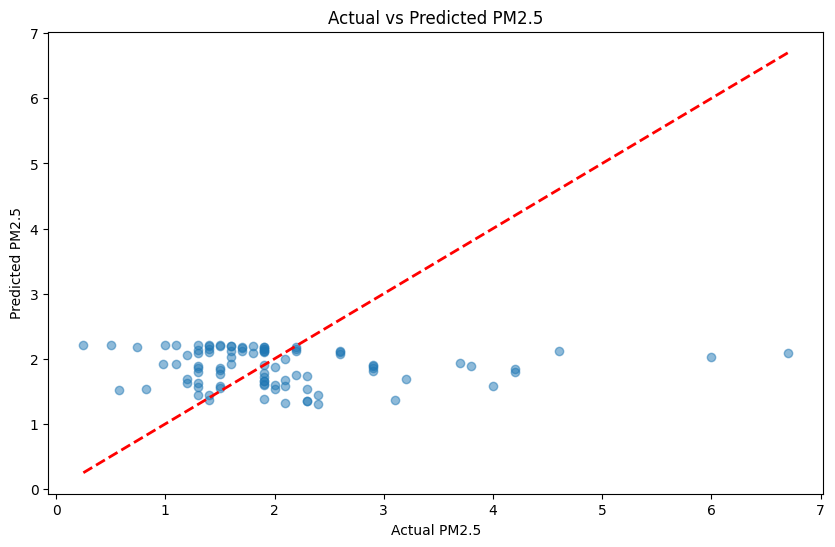

In [82]:

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.show()




In [83]:
torch.save(model.state_dict(), 'model_weights.pth')

In [84]:
model.load_state_dict(torch.load('model_weights.pth'))

/var/folders/z0/w8wxtq691l55jcqndh2hzmfh0000gn/T/ipykernel_59577/2178556627.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weigh

<All keys matched successfully>

In [85]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Scale the validation and test sets
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

In [86]:
def compute_accuracy(y_true, y_pred, threshold=0.5):
    correct = torch.abs(y_true - y_pred) < threshold
    return correct.float().mean().item()

In [87]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor)
    val_accuracy = compute_accuracy(y_val_tensor, y_val_pred)
    
print(f"Validation Accuracy (threshold=0.5): {val_accuracy:.4f}")

Validation Accuracy (threshold=0.5): 0.3913


In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

val_mae = mean_absolute_error(y_val, y_val_pred.numpy())
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred.numpy()))

print(f"Validation MAE: {val_mae:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

Validation MAE: 0.8049
Validation RMSE: 1.1346


In [89]:
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    test_accuracy = compute_accuracy(y_test_tensor, y_test_pred)
    
test_mae = mean_absolute_error(y_test, y_test_pred.numpy())
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred.numpy()))

print(f"Test Accuracy (threshold=0.5): {test_accuracy:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Test Accuracy (threshold=0.5): 0.5319
Test MAE: 0.7197
Test RMSE: 1.0372


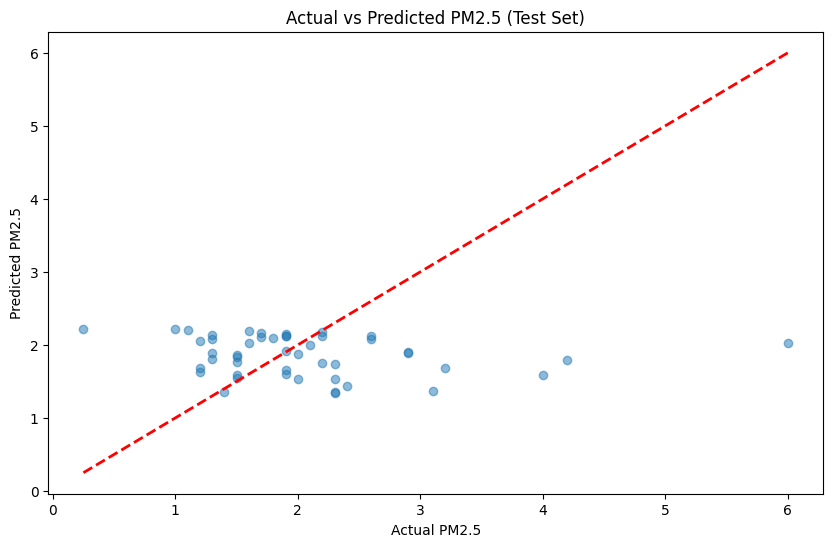

In [90]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred.numpy(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5 (Test Set)')
plt.show()

## Submitting your model for grading

We've integrated the scoring system into the qBraid platform. To submit your model, you'll need to first initialize a qBraid session and set up the IonQ/SCQ client.

In [ ]:
from qbraid.runtime import QbraidSession
from ionqvision.scq_client import IonQSCQClient

session = QbraidSession()

client = IonQSCQClient(session=session)

Now comes the exciting part! Use your classifier’s `submit_model_for_grading` method to submit your model for evaluation.

Your quantum layer and the trained weights will be serialized and then reassembled in a secure environment. We'll run inference on an unseen validation set using the reconstructed model to calculate your accuracy score.


In [ ]:
submission_data = classifier.submit_model_for_grading(client=client)

message = submission_data.get("message")
submission_id = submission_data.get("submissionId")

print(message)

It may take sometime to process the results.

In [ ]:
client.await_autograder_result(submission_id=submission_id)


After a few minutes, check [the live leaderboard](https://account.qbraid.com/hackathons/2024/crs4) to see how your team ranks!

🍀 Good luck! We hope you have a great time tackling this exciting challenge.🤞 🥳 🎉

# 👉 [The real-time leaderboard](https://account.qbraid.com/hackathons/2024/crs4)

Click the link above to know how you scored.